In [ ]:
%%capture
!pip install mne # Installing the MNE library

In [ ]:
import mne

In [ ]:
# Importing necessary libraries
import numpy as np
#import mne
import matplotlib.pyplot as plt

Model Architecture

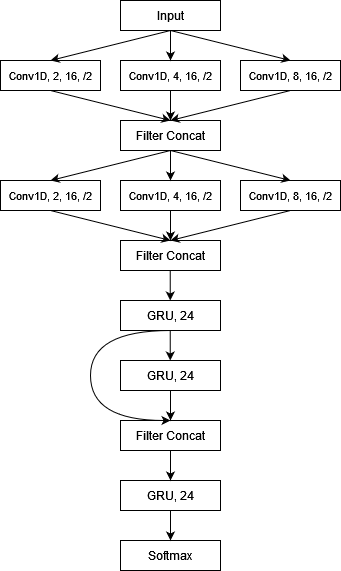

In [ ]:
# Importing pytorch neural network library
import torch.nn as nn
import torch

In [ ]:
# defining the class for Convolution block with inception module
class Block(nn.Module):
  def __init__(self, input_channels):
    super().__init__()
    # 3 different filters sizes of 2, 4 and 8
    self.conv1 = nn.Conv1d(in_channels = input_channels, out_channels = 16, kernel_size = 2, stride = 2, padding = 0)
    self.conv2 = nn.Conv1d(in_channels = input_channels, out_channels = 16, kernel_size = 4, stride = 2, padding = 1)
    self.conv3 = nn.Conv1d(in_channels = input_channels, out_channels = 16, kernel_size = 8, stride = 2, padding = 3)
    self.relu = nn.ReLU()

  def forward(self, x):
    x1 = self.relu(self.conv1(x))
    x2 = self.relu(self.conv2(x))
    x3 = self.relu(self.conv3(x))
    x = torch.cat([x1, x2, x3], dim = 1) # Filter Concatenation
    return x

In [ ]:
class ChronoNet(nn.Module):
  def __init__(self, channel):
    super().__init__()
    # 2 such convolutional blocks with inception module
    self.block1 = Block(channel)
    self.block2 = Block(48)
    # Followed by densely connected GRU Layers
    self.gru1 = nn.GRU(input_size = 48, hidden_size = 24, batch_first = True)
    self.gru2 = nn.GRU(input_size = 24, hidden_size = 24, batch_first = True)
    self.gru3 = nn.GRU(input_size = 48, hidden_size = 24, batch_first = True)
    self.gru_linear = nn.Linear(128, 1) # Used to flatten the output from the GRU layers
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(24, 1) # Final fully connected layer to the output unit
    self.relu = nn.ReLU()

  def forward(self, x): # Forward propogating the input x through the network
    x = self.block1(x)
    x = self.block2(x)
    x = x.permute(0,2,1)
    gru1_out, hn_1 = self.gru1(x)
    gru2_out, hn_2 = self.gru2(gru1_out)

    gru_out=torch.cat([gru1_out,gru2_out],dim=2)

    linear_out = self.relu(self.gru_linear(gru_out.permute(0,2,1)))
    gru3_out, hn_3 = self.gru3(linear_out.permute(0,2,1))

    x = self.flatten(gru3_out)
    x = self.fc1(x) # Final output
    return x

In [ ]:
# Getting the dataset
%%capture
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fshy54ypyh-3.zip

In [ ]:
# Unzipping the dataset
%%capture
!unzip fshy54ypyh-3.zip

In [ ]:
# Storing the paths of the data of the 2 classes (TDC & IDD) in 2 variables
TDC = '/content/fshy54ypyh-3/Data/CleanData/CleanData_TDC/Rest'
IDD = '/content/fshy54ypyh-3/Data/CleanData/CleanData_IDD/Rest'

In [ ]:
import scipy.io as sio

In [ ]:
S = sio.loadmat('/content/fshy54ypyh-3/Data/CleanData/CleanData_TDC/Rest/CGS01_Rest_CD.mat')

In [ ]:
S['clean_data'].shape

(14, 15360)

In [ ]:
# Creating MNE instance
n_channels = 14 # 14 EEG channels present in the data
sampling_freq = 256 # Setting the sampling frequency to 128 Hz
info = mne.create_info(n_channels, sfreq = sampling_freq) # Creating MNE instance
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
 chs: 14 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 256.0 Hz
>


In [ ]:
ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] # Setting the channel names and types
ch_types = ['eeg'] * 14
info = mne.create_info(ch_names, ch_types = ch_types, sfreq = sampling_freq)
info.set_montage('standard_1020') # Setting the montage to the international 10-20 standard

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 256.0 Hz
>

In [ ]:
# Function to convert the .mat data to readable numpy array
def convertmat2mne(data):
  # All previous steps mentioned above to create MNE instance
  ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
  ch_types = ['eeg'] * 14
  info = mne.create_info(ch_names, ch_types = ch_types, sfreq = sampling_freq)
  info.set_montage('standard_1020')

  data = mne.io.RawArray(data, info) # Getting raw MNE Array from data
  #mne.plot(data)
  data.plot()
  data.set_eeg_reference() # Setting the EEG reference to be used which is average by default
  data.filter(l_freq = 1, h_freq = 30) # Filter the data by frequency to reduce noise
  epochs = mne.make_fixed_length_epochs(data, duration = 4, overlap = 0) # Finally segmenting it to obtain clean data
  return epochs.get_data()

Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.
Using matplotlib as 2D backend.


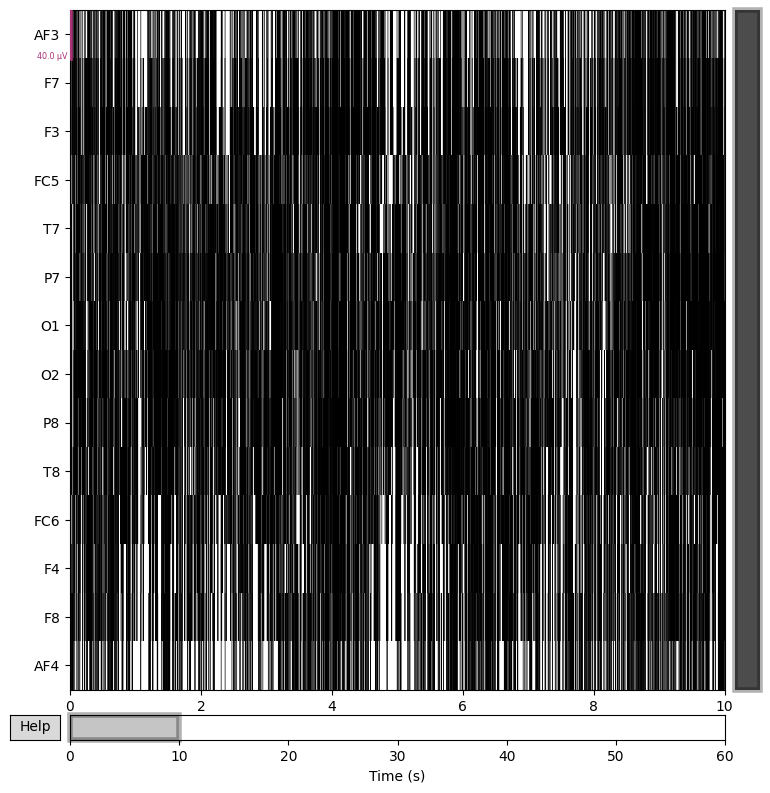

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


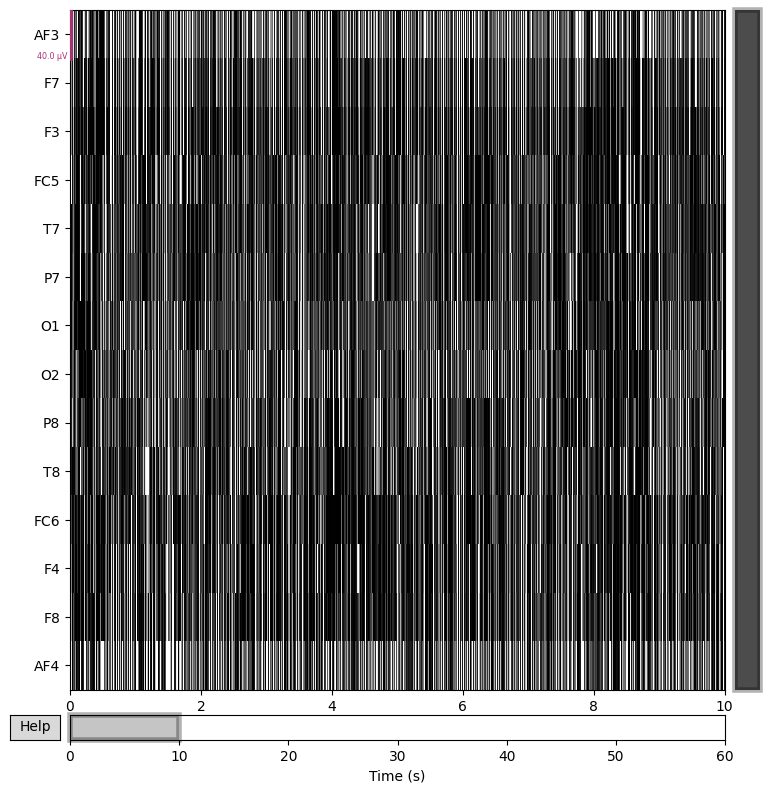

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


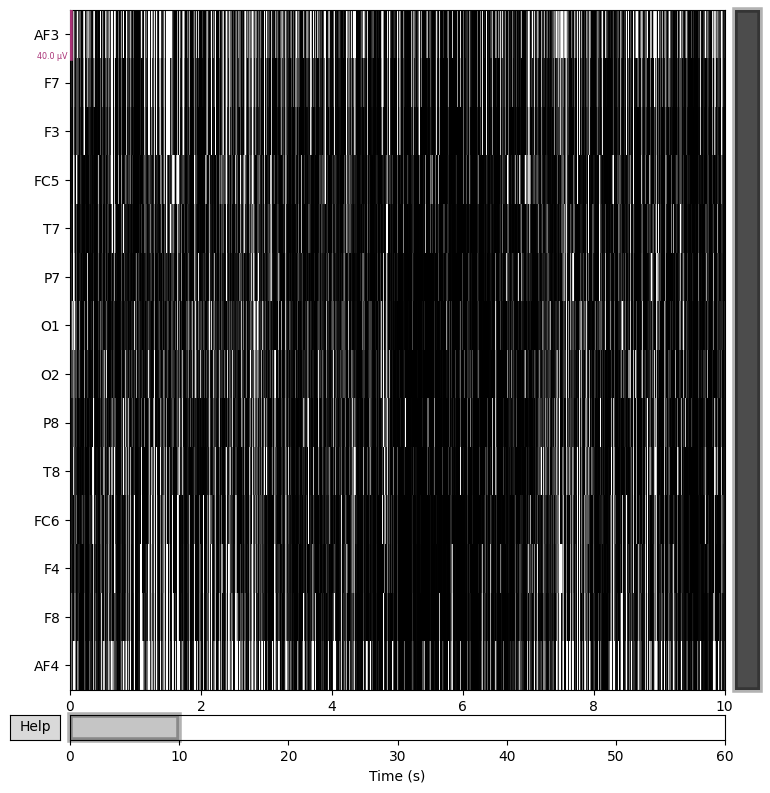

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


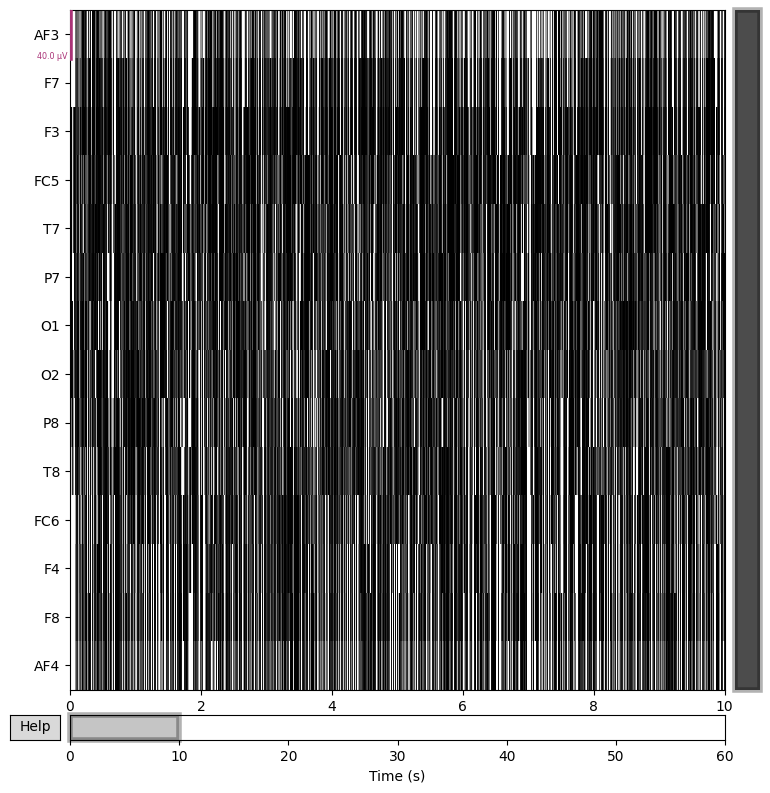

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished


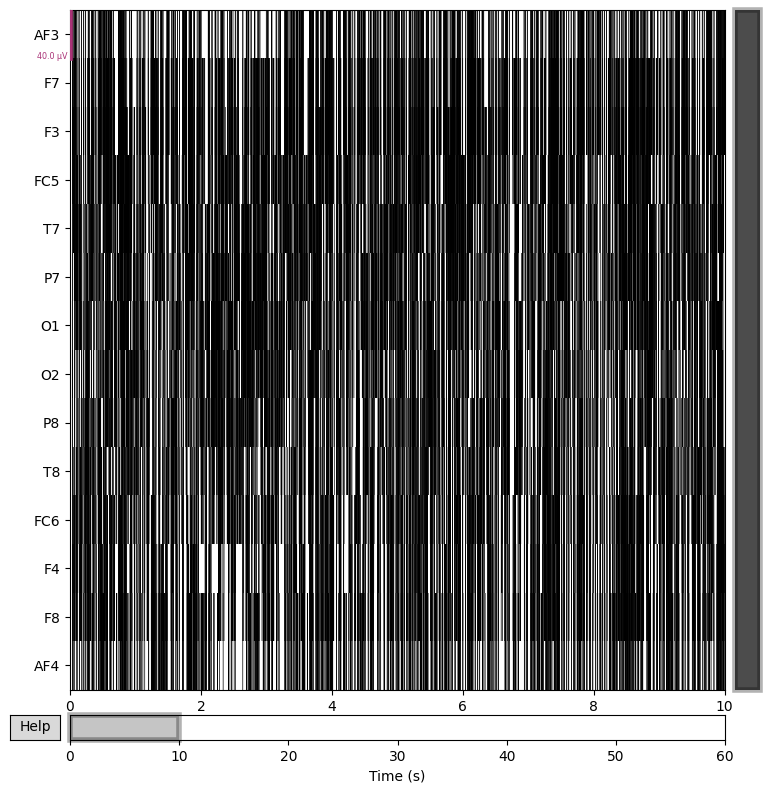

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished


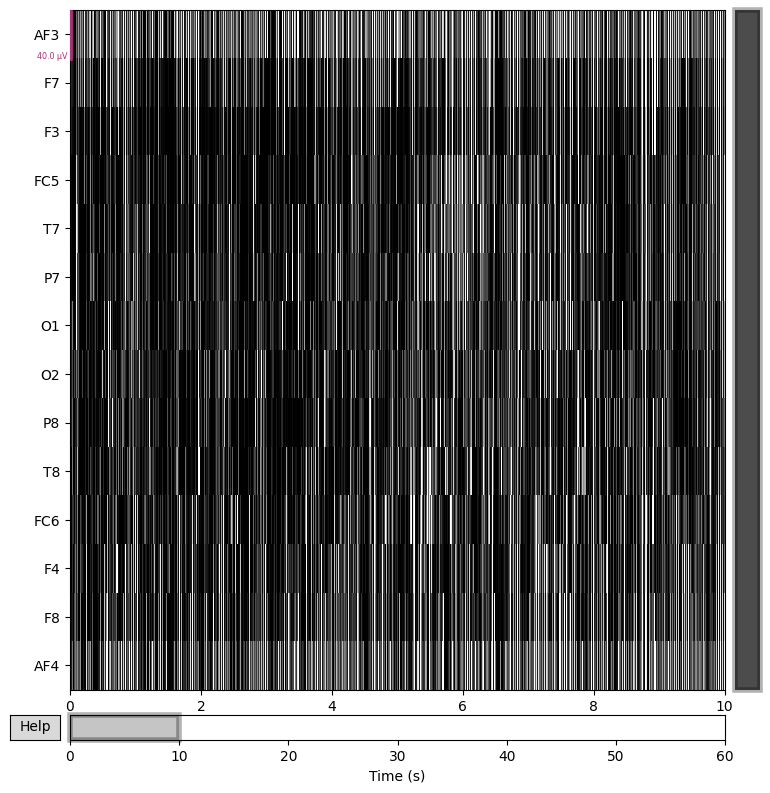

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


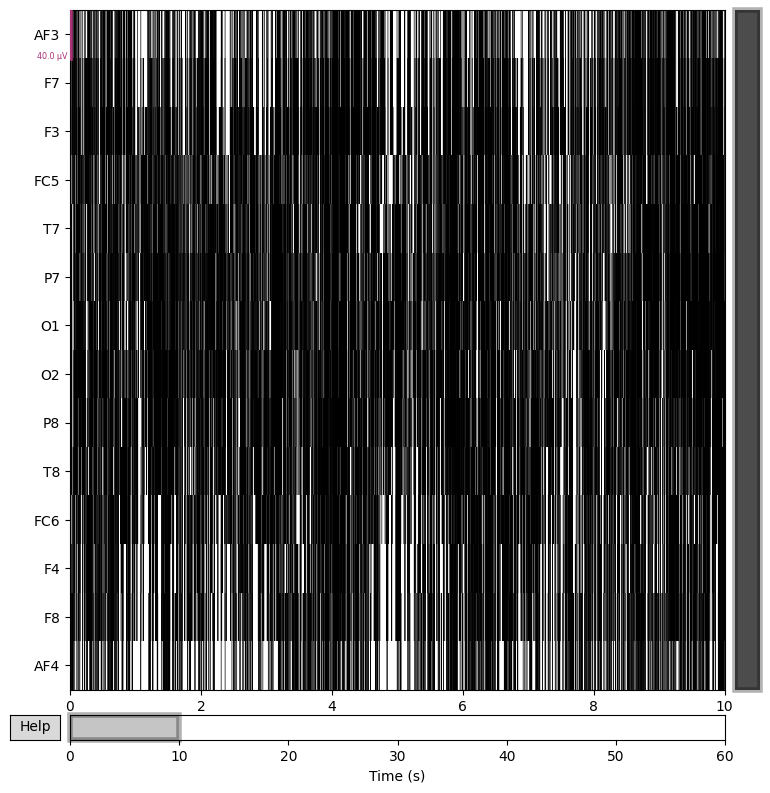

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


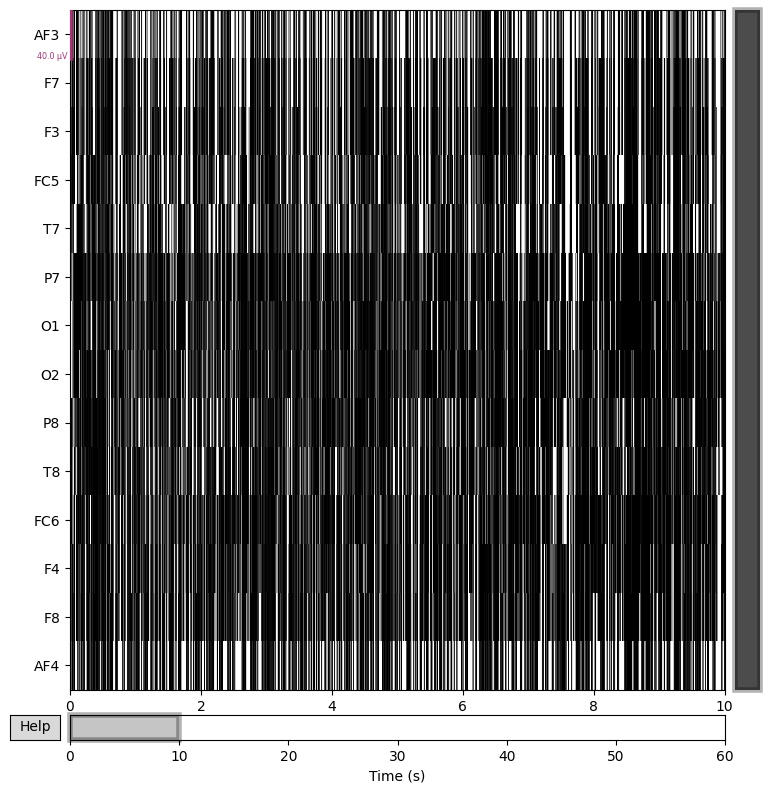

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


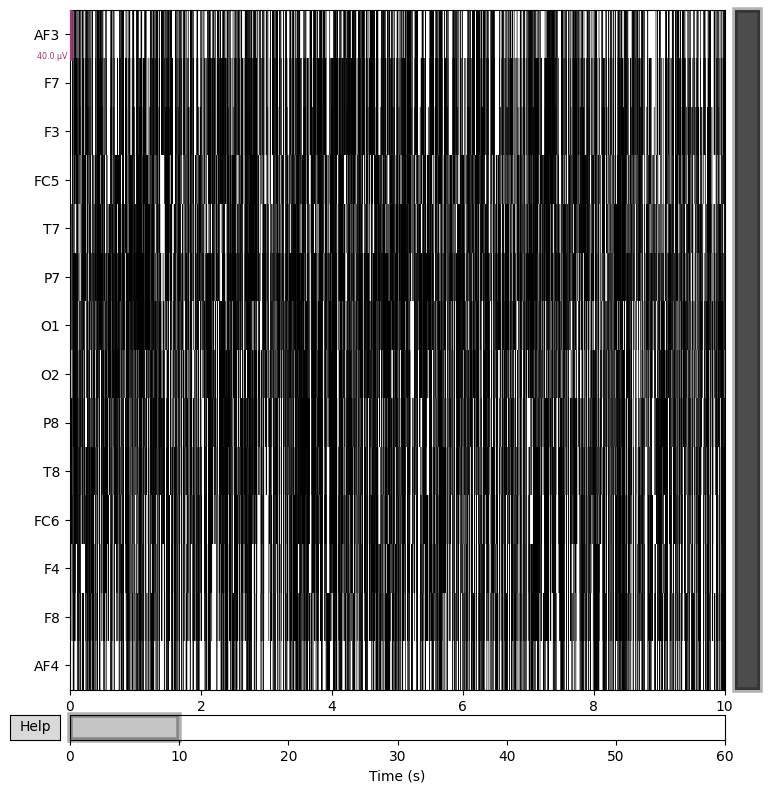

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


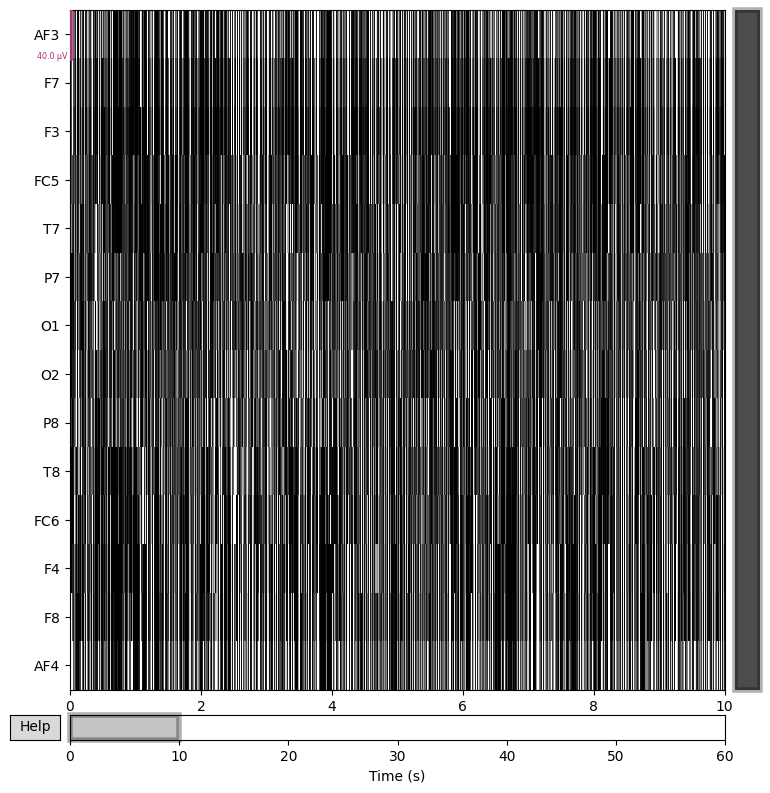

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


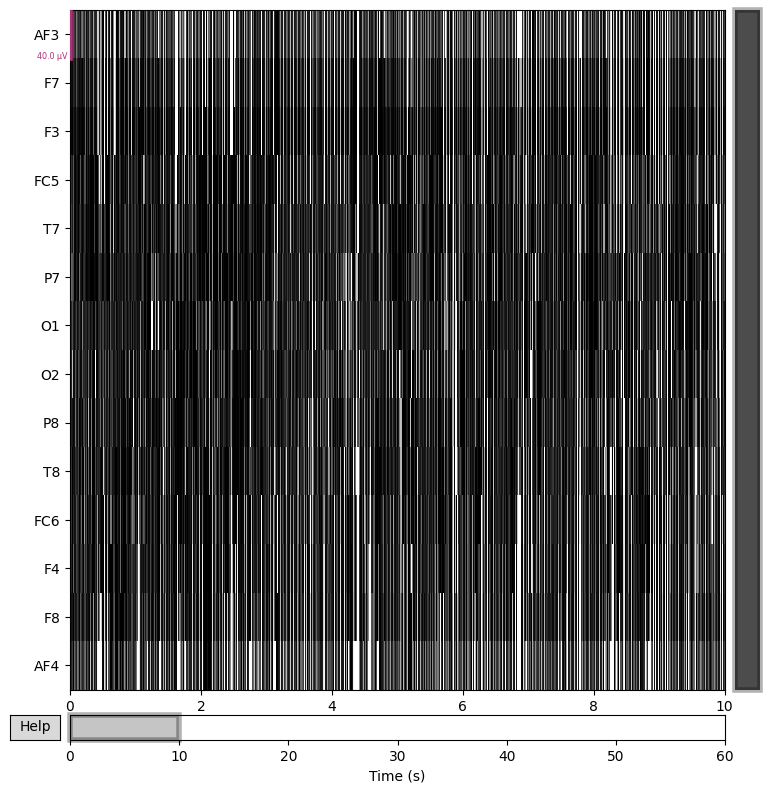

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


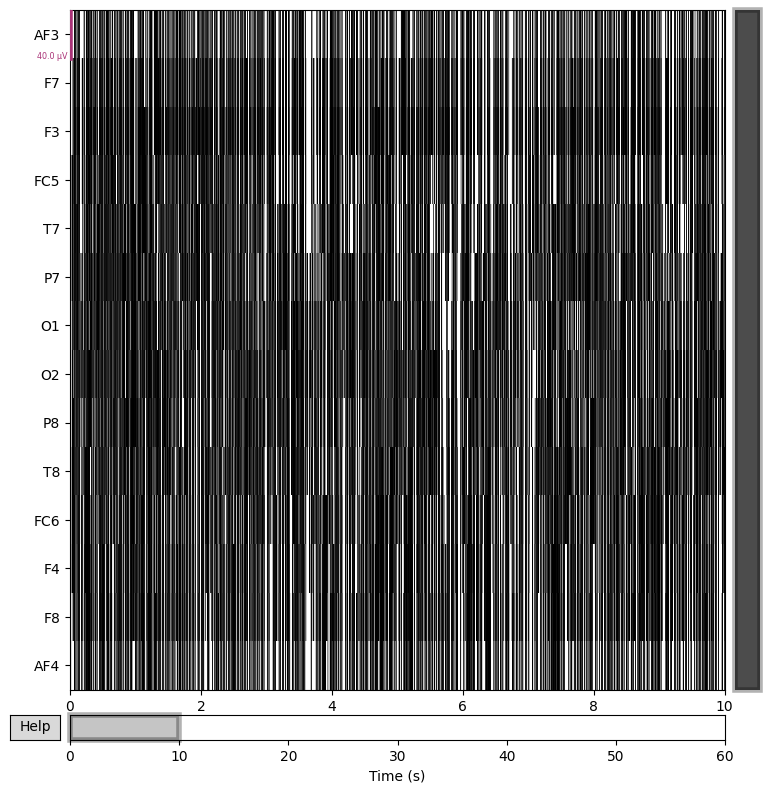

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


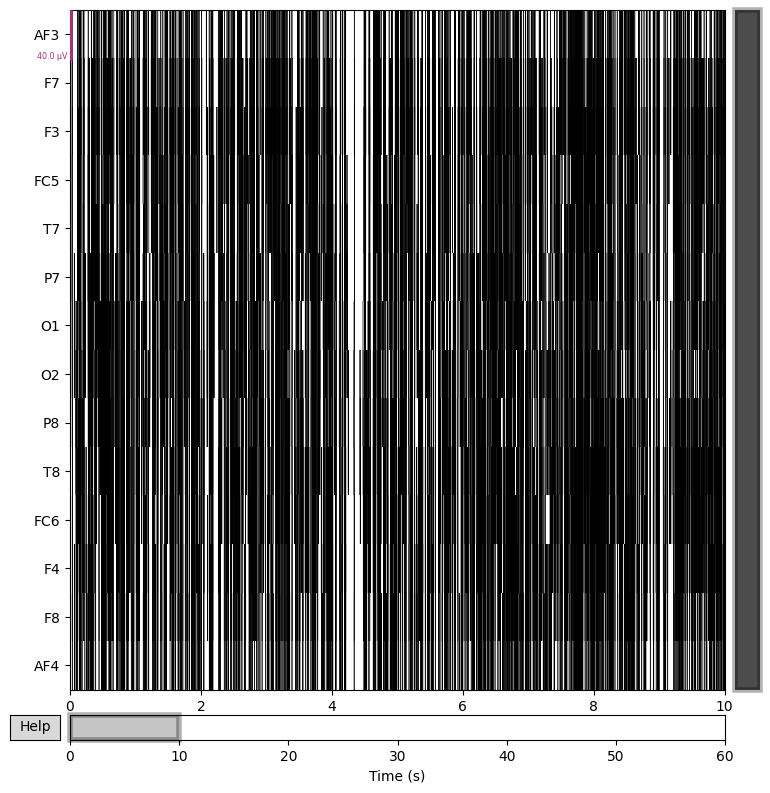

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


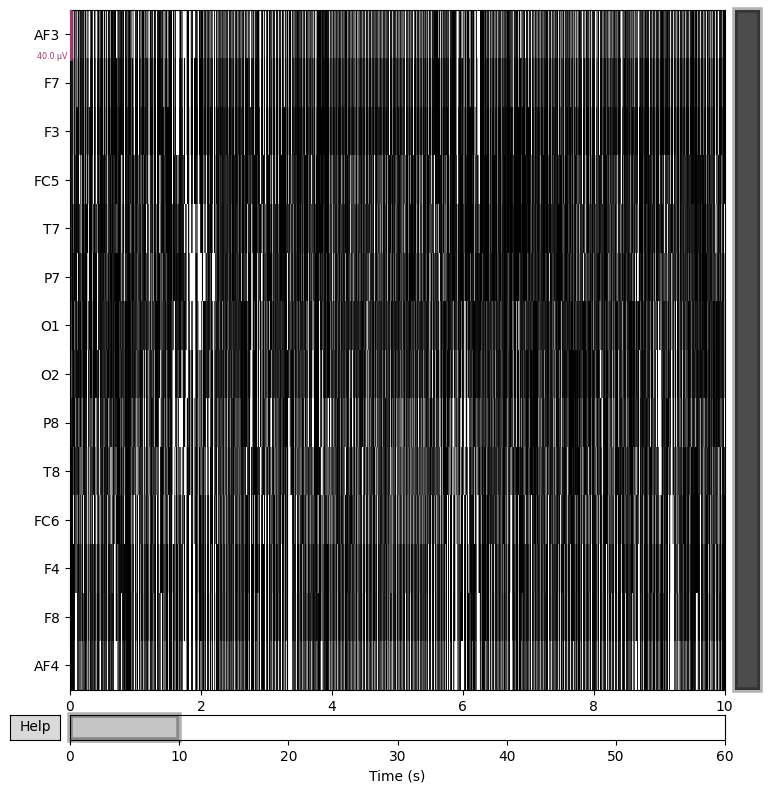

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


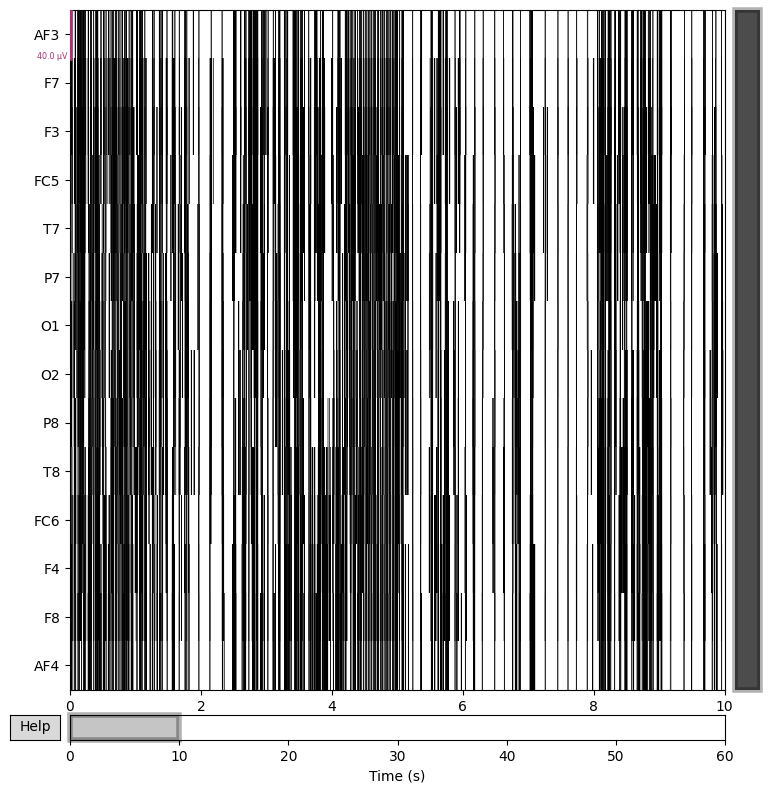

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


In [ ]:
from glob import glob
import scipy.io

# Storing the data of subjects belonging to 2 classes in 2 arrays

idd_subjects = []
for idd in glob(IDD + '/*.mat'):
  data = scipy.io.loadmat(idd)['clean_data']
  data = convertmat2mne(data)
  idd_subjects.append(data)

tdc_subjects = []
for tdc in glob(TDC + '/*.mat'):
  data = scipy.io.loadmat(tdc)['clean_data']
  data = convertmat2mne(data)
  tdc_subjects.append(data)

In [ ]:
# Setting labels of the 2 classes as 0 and 1
control_epochs_labels=[len(i)*[0] for i in tdc_subjects]
patients_epochs_labels=[len(i)*[1] for i in idd_subjects]
print(len(control_epochs_labels),len(patients_epochs_labels))

7 8


In [ ]:
data_list=tdc_subjects+idd_subjects
label_list=control_epochs_labels+patients_epochs_labels
print(len(data_list),len(label_list))

15 15


In [ ]:
# Grouping all the epochs subject wise, so that train test split can be done appropriately group - wise
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]

In [ ]:
groups_list

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
 [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
 [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
 [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]]

In [ ]:
# Using vstack and hstack to get 3d data in appropriate format
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(groups_list)
data_array=np.moveaxis(data_array,1,2)

print(data_array.shape,label_array.shape,group_array.shape) # [no. of epochs, length of the epoch, no. of channels]

(225, 1024, 14) (225,) (225,)


In [ ]:
# Importing libraries for training
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()


from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler

# Function for standard scaling of 3d data
class StandardScaler3d(BaseEstimator,TransformerMixin):

    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)

In [ ]:
# Splitting data into training and testing datasets
accuracy=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels = data_array[train_index],label_array[train_index]
    val_features,val_labels = data_array[val_index],label_array[val_index]
    scaler = StandardScaler3d()

    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)

    train_features = np.moveaxis(train_features,1,2)
    val_features = np.moveaxis(val_features,1,2)
    break

In [ ]:
X_train = np.moveaxis(train_features,1,2)
X_test = np.moveaxis(val_features,1,2)
y_train, y_test = train_labels, val_labels

In [ ]:
X_train.shape

(180, 1024, 14)

In [ ]:
train_features.shape, train_labels

((180, 14, 1024),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]))

In [ ]:
val_features.shape, val_labels

((45, 14, 1024),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]))

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Dense, Lambda, Flatten
from tensorflow.keras.models import Model

In [ ]:
    input_shape = X_train.shape[1:]
    num_classes = 2
    n_filters = 64
    kernel_size = 3
    dilation_rates = [2**i for i in range(8)]
    dropout_rate = 0.5

    inputs = Input(shape=input_shape)
    x = inputs
    for dilation_rate in dilation_rates:
        x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                  padding='causal', activation='relu')(x)
        x = Dropout(rate=dropout_rate)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    #x = Lambda(lambda x: tf.squeeze(x, axis=1))(x)

    model = Model(inputs=inputs, outputs=x)
    #model.summary()

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=128, epochs=75)

    score = model.evaluate(X_test, y_test, batch_size=128)

Epoch 1/75
2/2 [==============================] - 4s 51ms/step - loss: 1.2880 - accuracy: 0.4833
Epoch 2/75
2/2 [==============================] - 0s 49ms/step - loss: 1.0070 - accuracy: 0.4833
Epoch 3/75
2/2 [==============================] - 0s 38ms/step - loss: 0.9876 - accuracy: 0.5000
Epoch 4/75
2/2 [==============================] - 0s 37ms/step - loss: 0.6844 - accuracy: 0.5278
Epoch 5/75
2/2 [==============================] - 0s 37ms/step - loss: 0.6978 - accuracy: 0.5000
Epoch 6/75
2/2 [==============================] - 0s 36ms/step - loss: 0.7010 - accuracy: 0.5000
Epoch 7/75
2/2 [==============================] - 0s 36ms/step - loss: 0.7065 - accuracy: 0.5000
Epoch 8/75
2/2 [==============================] - 0s 35ms/step - loss: 0.6910 - accuracy: 0.5000
Epoch 9/75
2/2 [==============================] - 0s 36ms/step - loss: 0.6815 - accuracy: 0.5000
Epoch 10/75
2/2 [==============================] - 0s 36ms/step - loss: 0.6749 - accuracy: 0.5000
Epoch 11/75
2/2 [============

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 38ms/step - loss: 0.5359 - accuracy: 1.0000


In [ ]:
print(model.predict(X_test))

2/2 [==============================] - 1s 245ms/step
[[2.1536826e-01]
 [2.1311577e-01]
 [4.7666696e-01]
 [3.6909345e-01]
 [5.9348986e-06]
 [0.0000000e+00]
 [4.0310994e-01]
 [2.3367809e-01]
 [1.0234719e-02]
 [4.3942246e-01]
 [2.8794059e-01]
 [4.4168237e-01]
 [4.2769030e-01]
 [3.8067043e-01]
 [3.1970385e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]
 [5.3419393e-01]]


In [ ]:
# Converting
train_features = torch.Tensor(train_features)
train_labels = torch.Tensor(train_labels)
val_features = torch.Tensor(val_features)
val_labels = torch.Tensor(val_labels)

In [ ]:
train_features.shape

torch.Size([330, 14, 512])

In [ ]:
# Installing Pytorch Lightning Interface
%%capture
!pip install pytorch_lightning

In [ ]:
from pytorch_lightning import LightningModule,Trainer
import torchmetrics
from torch.utils.data import TensorDataset,DataLoader

In [ ]:
# Finally defining chronomodel class to for training and validation of data
class ChronoModel(LightningModule):
  def __init__(self):
    super(ChronoModel,self).__init__()
    self.model=ChronoNet(14)
    self.lr=1e-2
    self.bs=12
    self.worker=2
    self.acc = torchmetrics.Accuracy(task='binary')
    self.criterion=nn.BCEWithLogitsLoss()

  def forward(self,x):
    x=self.model(x)
    return x

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(),lr=self.lr)

  def train_dataloader(self):
    dataset=TensorDataset(train_features,train_labels)
    dataloader=DataLoader(dataset,batch_size=self.bs,num_workers=self.worker,shuffle=True)
    return dataloader

  def training_step(self,batch,batch_idx):
    signal,label=batch
    out=self(signal.float())
    loss=self.criterion(out.flatten(),label.float().flatten())
    acc=self.acc(out.flatten(),label.long().flatten())
    return {'loss':loss,'acc':acc}

  def trained_epoch_end(self,outputs):
    acc=torch.stack([x['acc'] for x in outputs]).mean().detach().cpu().numpy()#.round(2)
    loss=torch.stack([x['loss'] for x in outputs]).mean().detach().cpu().numpy()#.round(2)
    print('train acc loss',acc,loss)

  def val_dataloader(self):
    dataset=TensorDataset(val_features,val_labels)
    dataloader=DataLoader(dataset,batch_size=self.bs,num_workers=self.worker,shuffle=True)
    return dataloader

  def validation_step(self,batch,batch_idx):
    signal,label=batch
    out=self(signal.float())
    loss=self.criterion(out.flatten(),label.float().flatten())
    acc=self.acc(out.flatten(),label.long().flatten())
    return {'loss':loss,'acc':acc}

  def validation_epoch_end(self,outputs):
    acc=torch.stack([x['acc'] for x in outputs]).mean().detach().cpu().numpy()#.round(2)
    loss=torch.stack([x['loss'] for x in outputs]).mean().detach().cpu().numpy()#.round(2)
    print('val loss' ,loss, acc)

In [ ]:
# Training
model = ChronoModel()
trainer=Trainer(max_epochs=20)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ChronoNet         | 28.4 K
1 | acc       | BinaryAccuracy    | 0     
2 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
28.4 K    Trainable params
0         Non-trainable params
28.4 K    Total params
0.114     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


val loss 0.6971972 0.4166667


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val loss 0.065807596 0.9895834


Validation: 0it [00:00, ?it/s]

val loss 0.5863092 0.7083334


Validation: 0it [00:00, ?it/s]

val loss 0.004828076 1.0


Validation: 0it [00:00, ?it/s]

val loss 0.0024974225 1.0


Validation: 0it [00:00, ?it/s]

val loss 0.0016899105 1.0


Validation: 0it [00:00, ?it/s]

val loss 0.001264551 1.0


Validation: 0it [00:00, ?it/s]

val loss 0.001005583 1.0


Validation: 0it [00:00, ?it/s]

val loss 0.0008179688 1.0


Validation: 0it [00:00, ?it/s]

val loss 0.0006928586 1.0


Validation: 0it [00:00, ?it/s]

val loss 0.00058977905 1.0


Validation: 0it [00:00, ?it/s]

val loss 0.0005123276 1.0


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
